### 20200422: Downstream analyses of 3D genomic changes in _L. pneumophila_ infected _A. castellanii_
**cmdoret**

In this notebook, I investigate the biological role of regions detected as changing in 3D structure during infection of amoeba by _Legionella pneumophila_. To summarise the context, this is a follow-up on 2 analyses:

1. Genome assembly and annotation of _A. castellanii_ using ONT long reads, Hi-C, Illumina shotgun and RNAseq
2. Pattern detection in Hi-C maps from _A. castellanii_ and quantification of their change during infection.

I use the annotations generated in 1. to investigate potential roles of affected regions in 2.

In [1]:
# Load files and packages
from typing import List, Union, Iterable, Optional
import numpy as np
import pandas as pd
import os
import warnings
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import hicstuff.hicstuff as hcs
import hicstuff.view as hcv
import cooler
import pareidolia.io as pai
import pareidolia.hic_utils as pah
from cooltools.sample import sample_cooler


out = '../../data/output/'
indir = '../../data/input/'
res = 2000
samples = pd.read_csv('../../samples.tsv', sep='\t', comment='#')
infected_bedgraph = pd.read_csv(out + 'all_signals_AT420.bedgraph', sep='\t')
healthy_bedgraph = pd.read_csv(out + 'all_signals_AT421.bedgraph', sep='\t')
diff_borders = pd.read_csv(out + 'pareidolia/borders_change_infection_time.tsv', sep='\t')
diff_loops = pd.read_csv(out + 'pareidolia/loops_change_infection_time.tsv', sep='\t')
genes = pd.read_csv(indir + 'annotations/c3_annotations/Acanthamoeba_castellanii.annotations.txt', sep='\t')
# Remove genes which do not have an entrez id
#genes = genes.loc[~np.isnan(genes.entrezgene_id), :]
#genes.entrezgene_id = genes.entrezgene_id.astype(int)


In [2]:
# Manage cools, merge samples by condition to increase coverage in visualisations
def gather_and_merge_cools(condition: str, merged_out: str):
    cools = (
        samples.loc[samples.condition == condition, 'library']
        .apply(lambda p: f"{out}/cool/{p}.mcool::/resolutions/{res}")
        .tolist()
    )
    cooler.merge_coolers(merged_out, cools, mergebuf=10e8)
    
gather_and_merge_cools('uninfected', "healthy.cool")
gather_and_merge_cools('infected', "infected.cool")


INFO :: Merging:
../../data/output//cool/AT408.mcool::/resolutions/2000
../../data/output//cool/AT419.mcool::/resolutions/2000
../../data/output//cool/AT421.mcool::/resolutions/2000
INFO :: NumExpr defaulting to 8 threads.
INFO :: Creating cooler at "healthy.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: nnzs: [4627584, 552433, 1126529]
INFO :: current: [4627584, 552433, 1126529]
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: Merging:
../../data/output//cool/PM106.mcool::/resolutions/2000
../../data/output//cool/AT407.mcool::/resolutions/2000
../../data/output//cool/AT418.mcool::/resolutions/2000
../../data/output//cool/AT420.mcool::/resolutions/2000
INFO :: Creating cooler at "infected.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: nnzs: [5264991, 4340619, 2188053, 1290478]
INFO :: current: [5264991, 4340619, 2188053, 1290478]
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done


In [3]:

# Subsample cools to identical coverage between conditions
def subsample_cools(cools: List[str], cpus: int=8, balance: bool=True) -> List['cooler.Cooler']:
    if cpus > 1:
        import multiprocessing as mp
        pool = mp.Pool(cpus)
        my_map = pool.imap_unordered
    else:
        my_map = map
    coolers = pai.get_coolers(cools)
    target = pah.get_min_contacts(coolers)
    sub_cools = ["sub_" + cl for cl in cools]
    for i in range(len(cools)):
        sample_cooler(
            coolers[i],
            sub_cools[i],
            count=target-1,
            exact=False,
            map_func=my_map
        )
    sub_coolers = pai.get_coolers(sub_cools)
    # Balance the subsampled versions
    if balance:
        for clr in sub_coolers:
            cooler.balance_cooler(
                clr,store=True,
                map=my_map,
                mad_max=5,
                chunksize=10000000,
                min_nnz=10,
                max_iters=200,
                ignore_diags=2
            )
    if cpus > 1:
        pool.close()
    return sub_coolers

healthy_cool, infected_cool = subsample_cools(['healthy.cool', 'infected.cool'])

INFO :: Creating cooler at "sub_healthy.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: Creating cooler at "sub_infected.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: variance is 207516.34697497904
INFO :: variance is 178502.16030737796
INFO :: variance is 6544.085337267963
INFO :: variance is 22429.305388571323
INFO :: variance is 1312.8868220387121
INFO :: variance is 4614.804042505325
INFO :: variance is 551.437476836259
INFO :: variance is 1275.4518979136935
INFO :: variance is 272.5551871972193
INFO :: variance is 416.4542277161792
INFO :: variance is 131.6012513891975
INFO :: variance is 149.6246695039264
INFO :: variance is 60.937947542370544
INFO :: variance is 56.904008674450424
INFO :: variance is 27.298424416982797
INFO :: variance is 22.409915605047146
INFO :: variance is 11.949234535778

Only regions with p-values below 10e-3 are selected as potential candidates. When replicates will be available, I will use FDR instead of simple p-value.

In [4]:
def filter_patterns(df):
    filt = (df.loc[df.diff_score != 0.0, :]
      .sort_values(abs(df.diff_score))
      .reset_index(drop=True)
   )
    return filt
diff_borders = diff_borders.loc[diff_borders.diff_score != 0.0, :].reset_index(drop=True)
diff_loops = diff_loops.loc[diff_loops.diff_score != 0.0, :].reset_index(drop=True)
diff_borders.head()

,chrom1,start1,end1,chrom2,start2,end2,bin1,bin2,diff_score
0,scaffold_4,1496000,1498000,scaffold_4,1496000,1498000,4056.0,4056.0,0.226984
1,scaffold_2,1648000,1650000,scaffold_2,1648000,1650000,2030.0,2030.0,0.137458
2,scaffold_1,426000,428000,scaffold_1,426000,428000,213.0,213.0,0.152906
3,scaffold_1,1298000,1300000,scaffold_1,1298000,1300000,649.0,649.0,0.138742
4,scaffold_6,98000,100000,scaffold_6,98000,100000,5009.0,5009.0,0.172792


In [5]:
print(f"Keeping {diff_borders.shape[0]} borders and {diff_loops.shape[0]} loops with detectable change..")

Keeping 48 borders and 71 loops with detectable change..


In [6]:
def compute_di(mat, max_pix=10):
    """ Computes directionalitin index according to definition from Dixon et al., 2012"""
    
    di = np.zeros(mat.shape[0])
    for i in range(mat.shape[0]):
        before = np.nanmean(mat[i - max_pix: i, i -  max_pix: i])
        after = np.nanmean(mat[i: i + max_pix, i: i +  max_pix])
        expected = (before + after ) / 2
        sign = ((before - after) / np.abs(before - after))
        di[i] = sign * (((after - expected)**2) / expected + ((before - expected)**2) / expected)
    di[:max_pix] = 0
    di[-max_pix:] = 0
    high = np.nanmax(np.abs(di))
    di /= high # Scale to 1
    return di

In [17]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9.0, 6.0)
# Show example regions
def plot_regions(healthy_cool, infected_cool, df, region_id, region_size=100000, blur=0):
    
    def region_lines(ax, s, e):
        """Add lines to mark region of differential contacts"""
        style = {"lw": 0.5, "alpha": 0.6, "c": "g"}
        for i in range(3):
            ax[0, i].axvline(x=s, **style)
            ax[0, i].axvline(x=e, **style)
            ax[0, i].axhline(y=s, **style)
            ax[0, i].axhline(y=e, **style)
            ax[1, i].axvline(x=s, **style)
            ax[1, i].axvline(x=e, **style)
            
    
    def nan_gaussian(U, sigma):
        """Gaussian filter which does not include NAs"""
        import scipy.ndimage as ndi
        V=U.copy()
        V[np.isnan(U)]=0
        VV=ndi.gaussian_filter(V, sigma=sigma)
        W=0*U.copy()+1
        W[np.isnan(U)]=0
        WW=ndi.gaussian_filter(W, sigma=sigma)
        Z=VV/WW   
        return Z
    
    # Extract region of interest
    region = df.iloc[region_id]
    chrom, start, end = region.chrom1, region.start1, region.end1
    pos = (start + end) / 2
    ucsc_query = f'{chrom}:{int(max(0, pos-region_size))}-{int(pos+region_size)}'
    
    # Subset matrix
    healthy_zoom = healthy_cool.matrix(balance=True).fetch(ucsc_query)
    infected_zoom = infected_cool.matrix(balance=True).fetch(ucsc_query)
    infected_zoom[np.isnan(infected_zoom)] = 0.0
    healthy_zoom[np.isnan(healthy_zoom)] = 0.0
    
    # Blur ratio to improve readability
    if blur > 0:
        infected_blur = nan_gaussian(infected_zoom, sigma=blur)
        healthy_blur = nan_gaussian(healthy_zoom, sigma=blur)
    else:
        infected_blur = infected_zoom
        healthy_blur = healthy_zoom

    log_ratio = np.log2(infected_blur / healthy_blur)
    #log_ratio[np.isnan(infected_zoom)] = 0.0
    #log_ratio[np.isnan(healthy_zoom)] = 0.0
    
    # Initialize figure
    fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, gridspec_kw={'height_ratios': [5, 1]})
    
    # Draw lines
    region_size = (end - start) // healthy_cool.binsize
    mid = healthy_zoom.shape[0] // 2
    start_bin, end_bin = mid - region_size, mid + region_size
    region_lines(ax, start_bin, end_bin)
    
    # Make heatmap
    plt.suptitle(f"{chrom}:{start}-{end}")
    ax[0, 0].imshow(np.log2(infected_zoom), cmap="Reds")
    ax[0, 0].set_title("Infected")
    ax[0, 1].imshow(np.log2(healthy_zoom), cmap="Reds")
    ax[0, 1].set_title("Uninfected")
    ax[0, 2].imshow(log_ratio, cmap='bwr', vmin=-2, vmax=2)
    ax[0, 2].set_title("I / U")
    
    # Plot DI
    n = infected_zoom.shape[0]
    infected_di = compute_di(infected_zoom, max_pix=10)
    healthy_di = compute_di(healthy_zoom, max_pix=10)
    
    for i in range(3): ax[1, i].set_ylim(-1, 1, emit=False)
    for i in range(3): ax[1, i].axhline(0, lw=0.5, c='black')
    ax[1, 0].plot(range(n), infected_di)
    ax[1, 1].plot(range(n), healthy_di)
    ax[1, 2].plot(range(n), infected_di - healthy_di)



from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#show_inter_chr(ot_mat, chrA='chr03', chrB='chr08', var='repeats_prop')
region_size_slider = widgets.IntSlider(min=10000, max=500000, step=2000, value=100000)
blur_slider = widgets.FloatSlider(min=0, max=4, step=0.1, value=0)
pl = interactive(plot_regions, healthy_cool=fixed(healthy_cool),
                 infected_cool=fixed(infected_cool),
                 df=fixed(diff_borders),
                 region_id=range(diff_borders.shape[0]),
                 region_size=region_size_slider,
                 blur=blur_slider
                )
#display(pl)
display(pl)
plt.savefig('test.svg')

interactive(children=(Dropdown(description='region_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<Figure size 648x432 with 0 Axes>

In [18]:
%matplotlib inline
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9.0, 6.0)
# Show example regions


#show_inter_chr(ot_mat, chrA='chr03', chrB='chr08', var='repeats_prop')
pl = interactive(plot_regions, healthy_cool=fixed(healthy_cool),
                 infected_cool=fixed(infected_cool),
                 df=fixed(diff_loops),
                 region_id=range(diff_loops.shape[0]),
                 region_size=region_size_slider,
                 blur=blur_slider
                )
#display(pl)
display(pl)
plt.savefig('test.svg')

interactive(children=(Dropdown(description='region_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<Figure size 648x432 with 0 Axes>

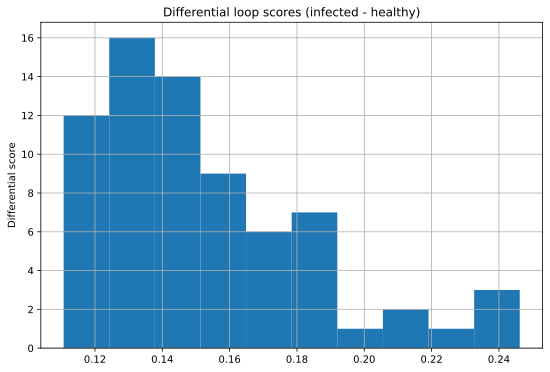

In [26]:
diff_loops.diff_score.hist()
plt.title("Differential loop scores (infected - healthy)")
plt.ylabel("N loops")
plt.ylabel("Differential score")

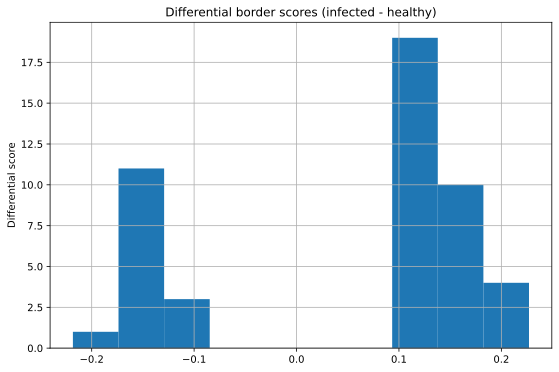

In [27]:
diff_borders.diff_score.hist()
plt.title("Differential border scores (infected - healthy)")
plt.ylabel("N borders")
plt.ylabel("Differential score")

All genes that overlap regions of differential contacts are then selected. This may not be optimal because genes may be separated from their enhancer element without being affected directly. This can happen if a domain boundary moves into the sequence between gene and enhancer.

The enrichment of GO terms (annotations) within regions with altered chromatin conformation is then tested to check for specific pathways or funcions.

In [29]:
import pyranges as pr


     |████████████████████████████████| 673 kB 850 kB/s eta 0:00:01
     |████████████████████████████████| 463 kB 707 kB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 346 kB 872 kB/s eta 0:00:01
  Using cached natsort-7.0.1-py3-none-any.whl (33 kB)
  Created wheel for pyranges: filename=pyranges-0.0.77-py3-none-any.whl size=683625 sha256=eeec32f6d666a1001399157f677a8a861e8e1152d865a06663ba3e8bda3aaf21
  Stored in directory: /home/cyril/.cache/pip/wheels/b4/76/4b/f767bd7dd49fdc4ecd91c92004ee99453e7202f5ed03b50c05
  Created wheel for ncls: filename=ncls-0.0.53-cp37-cp37m-linux_x86_64.whl size=1797706 sha256=0641fbad101e1d45dffe28eee1162876ba8304a6e5c942d1a6e4d58b184c025b
  Stored in directory: /home/cyril/.cache/pip/wheels/b9/5a/6e/14e0fa19b2c9749376eb91aa956485565bd4a3e7d37ec438aa
  Created wheel for sorted-nearest: filename=sorted_nearest-0.0.31-cp37-cp37m-linux_x86_64.whl size=4342733 sha256=d5d83011ce8d5ed78

In [ ]:
# Overlap with annotations
genes_bed_path = indir + 'tracks/mm10_annotations.bed'
(genes
 .loc[:, ["chromosome_name", "start_position", "end_position", "ensembl_gene_id"]]
 .to_csv(genes_bed_path, header=None, index=False, sep='\t')
)
genes_bed = pybedtools.BedTool(indir + 'tracks/mm10_annotations.bed')
diff_bed = pybedtools.BedTool(out + 'sig_diff.bed')
genes_inter_diff = genes_bed.intersect(diff_bed)
genes_inter_diff.saveas(out+'genes_diff.bed')


In [ ]:
# Get corresponding GO terms
genes_diff = pd.read_csv(out+'genes_diff.bed', sep='\t', names=["chrom", "start", "end", "ensembl_gene_id"])
genes_diff = genes_diff.merge(genes, left_on="ensembl_gene_id", right_on="ensembl_gene_id", how="inner")



In [ ]:
# Download GO association data required for enrichment test
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")
# Read NCBI's gene2go. Store annotations in a list of namedtuples
# taxid 10090 is Mus musculus
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

In [ ]:
exp_all_genes = {x: GeneID2nt_mus[x] for x in genes.entrezgene_id if x in GeneID2nt_mus.keys()}
exp_diff_genes = {x: GeneID2nt_mus[x] for x in genes_diff.entrezgene_id if x in GeneID2nt_mus.keys()}

In [ ]:
exp_diff_genes

In [ ]:
# Build GO enrichment analysis object

goeaobj = GOEnrichmentStudyNS(
        exp_all_genes.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

In [ ]:
# Run gene ontology enrichment analysis
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
geneids_study = exp_diff_genes.keys()
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

When running the analysis with a stringent threshold of pvalue < 10-4, I get no enriched biological process or molecular function, but only cellular component "Nucleosome" with genes Tnp2, Prm1, Prm2 and Prm3.

When running the analysis with less stringent filter pvalue < 10-3, I get enrichment for biological processes keratinization, keratinocyte differentiation and peptide cross linking. This is due to a group of several Sprr genes in the region at chr3:92Mb-94Mb

In [ ]:
%matplotlib notebook
# Save and visualize results
gene2sym = { k: v.Symbol for k, v in exp_diff_genes.items()}
goeaobj.wr_txt(out+"go_enrichment.txt", goea_results_sig)
plot_results(out+"mouse_salmonella_GO_enriched_{NS}.png",
             goea_results_sig,
             id2symbol=gene2sym,
             study_items=6)


In [ ]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_BP.png")
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_CC.png")
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_MF.png")
plt.figure()
plt.imshow(img)
plt.show()